In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve

from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import Adam


%matplotlib inline

In [2]:
#change read limit to -1 to load entire dataframe
df_bus_dens = utils.chunk_loader('data/cleaned/business_merge_density_added.csv', read_limit=-1)

df_bus_dens = utils.make_num_df(df_bus_dens)

X_train, X_test, y_train, y_test = utils.train_test_scale (df_bus_dens, 
                                                           'is_open', 
                                                           random_state=None)

#apply oversampling
X_train, y_train = utils.oversample(X_train, y_train)

In [3]:
# define the keras model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='softmax'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# compile the keras model

optim = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', 
              optimizer=optim, 
              metrics=['accuracy'])

In [5]:
#define params
batch_size= int(X_train.shape[0]/20)
epochs=50
validation_split=0.15

In [6]:
# fit the keras model on the dataset
hist = model.fit(X_train, y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          validation_split=validation_split, 
          verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 198910 samples, validate on 35102 samples
Epoch 1/50
198910/198910 [==============================] - 48s 243us/step - loss: 0.6869 - acc: 0.5531 - val_loss: 0.6681 - val_acc: 0.5514
Epoch 2/50
198910/198910 [==============================] - 51s 258us/step - loss: 0.6310 - acc: 0.6077 - val_loss: 0.6997 - val_acc: 0.6668
Epoch 3/50
198910/198910 [==============================] - 53s 267us/step - loss: 0.6182 - acc: 0.6602 - val_loss: 0.5890 - val_acc: 0.6766
Epoch 4/50
198910/198910 [==============================] - 79s 398us/step - loss: 0.5839 - acc: 0.6779 - val_loss: 0.5864 - val_acc: 0.6879
Epoch 5/50
198910/198910 [==============================] - 75s 376us/step - loss: 0.5775 - acc: 0.6855 - val_loss: 0.5970 - val_acc: 0.6810
Epoch 6/50
198910/198910 [==============================] - 58s 291us/step - loss: 0.5870 - acc: 0.6848 - val_loss: 0.5802 - val_acc: 0.6942
Epoch 7/50
198910/198910 [=============================

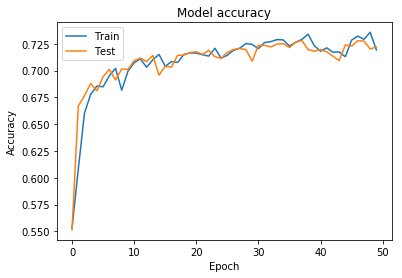

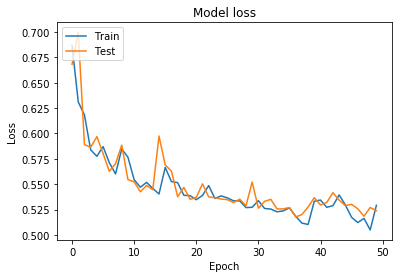

In [7]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.38      0.68      0.48      6072
           1       0.91      0.74      0.81     26160

    accuracy                           0.73     32232
   macro avg       0.64      0.71      0.65     32232
weighted avg       0.81      0.73      0.75     32232

----------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


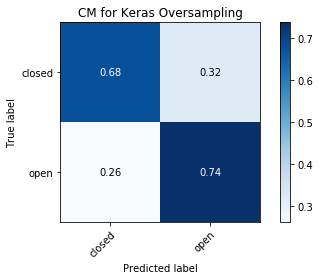

----------


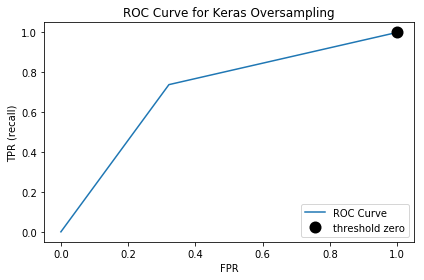

Area Under Curve = 0.7084
----------


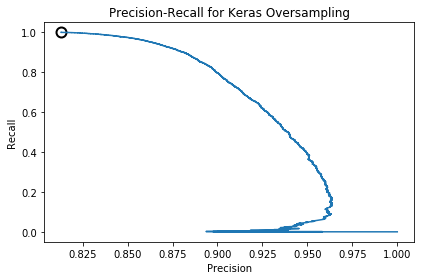

In [8]:
# make probability predictions with the model
y_pred_proba = model.predict(X_test)

y_pred = np.round(y_pred_proba)

print(classification_report(y_test, y_pred))
print(10*'-')
plot_help.plot_confusion_matrix(y_test, 
                                y_pred, 
                                ['closed', 'open'], normalize=True,
                                title='Keras Oversampling')
print(10*'-')
plot_help.plot_roc_curve(y_test, 
                         y_pred, 
                         'Keras Oversampling')
print(10*'-')
plot_help.plot_prc_curve(y_test, 
                         y_pred_proba, 
                         'Keras Oversampling')

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("classifiers/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("classifiers/model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
# load json and create model
json_file = open('classifiers/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("classifiers/model.h5")
print("Loaded model from disk")

Loaded model from disk
